参照资料：
- https://github.com/Kulbear/deep-learning-coursera/blob/master/Improving%20Deep%20Neural%20Networks%20Hyperparameter%20tuning%2C%20Regularization%20and%20Optimization/Initialization.ipynb
- https://blog.csdn.net/u013733326/article/details/79847918

在这篇文章中，我们讲要做以下三件事：
- 初始化参数

  - 使用0来初始化参数

  - 使用随机数来初始化参数

  - 使用抑梯度异常初始化参数（参见吴恩达-深度学习中的梯度消失、梯度爆炸）

- 正则化模型：

  - 使用二范数对二分类模型正则化，尝试避免过拟合
  - 使用随机删除节点的方法精简模型，同样是为了尝试避免过拟合

- 梯度校验：

  - 对模型使用梯度校验，检测它是否在梯度下降的过程中出现误差过大的情况

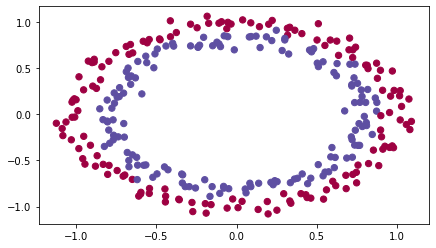

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import init_utils   #第一部分，初始化
import reg_utils    #第二部分，正则化
import gc_utils     #第三部分，梯度校验
from testCases import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = init_utils.load_dataset(is_plot=True)

我们将要建立一个分类器把蓝点和红点分开

# Initialization
##  1 - Neural Network model

在这之前我们已经实现过一个3层的神经网络，我们将对其初始化，以下是三种是我们即将尝试的方法：
- 初始化为0：在输入参数中全部初始化为0，参数名为initialization = “zeros”，核心代码：`parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l - 1]))`
- 初始化为随机数：把输入参数设置为随机值，权重初始化为大的随机值。参数名为initialization = “random”，核心代码：`parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 10`
- 抑梯度异常初始化：参见梯度消失和梯度爆炸的那一个视频，参数名为initialization = “he”，核心代码：`parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])`

让我们来看看我们的模型是怎样的：

In [6]:
def model(X,Y,learning_rate=0.01,num_iterations=15000,print_cost=True,initialization="he",is_polt=True):
    """
    实现一个三层的神经网络：LINEAR ->RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    
    参数：
        X - 输入的数据，维度为(2, 要训练/测试的数量)
        Y - 标签，【0 | 1】，维度为(1，对应的是输入的数据的标签)
        learning_rate - 学习速率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每迭代1000次打印一次
        initialization - 字符串类型，初始化的类型【"zeros" | "random" | "he"】
        is_polt - 是否绘制梯度下降的曲线图
    返回
        parameters - 学习后的参数
    """
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0],10,5,1]
    
    #选择初始化参数的类型
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    else : 
        print("错误的初始化参数！程序退出")
        exit
    
    #开始学习
    for i in range(0,num_iterations):
        #前向传播
        a3 , cache = init_utils.forward_propagation(X,parameters)
        
        #计算成本        
        cost = init_utils.compute_loss(a3,Y)
        
        #反向传播
        grads = init_utils.backward_propagation(X,Y,cache)
        
        #更新参数
        parameters = init_utils.update_parameters(parameters,grads,learning_rate)
        
        #记录成本
        if i % 1000 == 0:
            costs.append(cost)
            #打印成本
            if print_cost:
                print("第" + str(i) + "次迭代，成本值为：" + str(cost))
        
    
    #学习完毕，绘制成本曲线
    if is_polt:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    #返回学习完毕后的参数
    return parameters

## 2 - Zero initialization

In [7]:

def initialize_parameters_zeros(layers_dims):
    """
    将模型的参数全部设置为0
    
    参数：
        layers_dims - 列表，模型的层数和对应每一层的节点的数量
    返回
        parameters - 包含了所有W和b的字典
            W1 - 权重矩阵，维度为（layers_dims[1], layers_dims[0]）
            b1 - 偏置向量，维度为（layers_dims[1],1）
            ···
            WL - 权重矩阵，维度为（layers_dims[L], layers_dims[L -1]）
            bL - 偏置向量，维度为（layers_dims[L],1）
    """
    parameters = {}
    
    L = len(layers_dims) #网络层数
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.zeros((layers_dims[l],layers_dims[l-1]))
        parameters["b" + str(l)] = np.zeros((layers_dims[l],1))
        
        #使用断言确保我的数据格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l],layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l],1))
        
    return parameters

In [8]:
parameters = initialize_parameters_zeros([3,2,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


我们发现W、b全部被初始化为0了，那么我们使用这些参数来训练模型，结果会如何？

第0次迭代，成本值为：0.6931471805599453
第1000次迭代，成本值为：0.6931471805599453
第2000次迭代，成本值为：0.6931471805599453
第3000次迭代，成本值为：0.6931471805599453
第4000次迭代，成本值为：0.6931471805599453
第5000次迭代，成本值为：0.6931471805599453
第6000次迭代，成本值为：0.6931471805599453
第7000次迭代，成本值为：0.6931471805599453
第8000次迭代，成本值为：0.6931471805599453
第9000次迭代，成本值为：0.6931471805599453
第10000次迭代，成本值为：0.6931471805599455
第11000次迭代，成本值为：0.6931471805599453
第12000次迭代，成本值为：0.6931471805599453
第13000次迭代，成本值为：0.6931471805599453
第14000次迭代，成本值为：0.6931471805599453


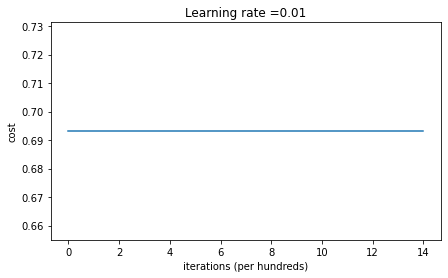

In [9]:
parameters = model(train_X, train_Y, initialization = "zeros",is_polt=True)

从上图我们可以看到，学习率一直没有变化，也就是说这个模型根本没有学习，让我们来看看预测的结果怎么样

In [10]:
print ("训练集:")
predictions_train = init_utils.predict(train_X, train_Y, parameters)
print ("测试集:")
predictions_test = init_utils.predict(test_X, test_Y, parameters)

训练集:
Accuracy: 0.5
测试集:
Accuracy: 0.5


性能确实很差，而且成本没有真正降低，算法的性能也比随机猜测要好，让我们看看预测和决策边界的细节：

predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


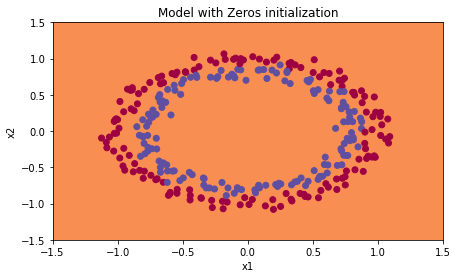

In [11]:
print("predictions_train = " + str(predictions_train))
print("predictions_test = " + str(predictions_test))

plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 1.5])
axes.set_ylim([-1.5, 1.5])
init_utils.plot_decision_boundary(lambda x: init_utils.predict_dec(parameters, x.T), train_X, train_Y)

分类失败，该模型预测每个都为0，零初始化导致神经网络无法打破对称性，最终导致结果就是无论网络有多少层，最终只能得到Logistic函数相同的效果

## 3 - Random initialization

为了打破对称性，我们可以随机把参数赋值，在随机初始化后，每个神经元可以开始学习其输入的不同功能，我们还会设置比较大的参数值，让我们来看看会发生什么

In [13]:
def initialize_parameters_random(layers_dims):
    """
    参数：
        layers_dims - 列表，模型的层数和对应每一层的节点的数量
    返回
        parameters - 包含了所有W和b的字典
            W1 - 权重矩阵，维度为（layers_dims[1], layers_dims[0]）
            b1 - 偏置向量，维度为（layers_dims[1],1）
            ···
            WL - 权重矩阵，维度为（layers_dims[L], layers_dims[L -1]）
            b1 - 偏置向量，维度为（layers_dims[L],1）
    """
    
    np.random.seed(3)               # 指定随机种子
    parameters = {}
    L = len(layers_dims)            # 层数
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 10 #使用10倍缩放
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
        #使用断言确保我的数据格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l],layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l],1))
        
    return parameters

In [14]:
parameters = initialize_parameters_random([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]


这些参数都比较大，让我们来看看实际运行会怎么样：

C:\Users\20919\PycharmProjects\wuenda-DeepLearning\Improve deep neural networks\Initialization,Regularization,Gradient Checking\init_utils.py:50: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\20919\PycharmProjects\wuenda-DeepLearning\Improve deep neural networks\Initialization,Regularization,Gradient Checking\init_utils.py:50: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第0次迭代，成本值为：inf
第1000次迭代，成本值为：0.6250982793959966
第2000次迭代，成本值为：0.5981216596703697
第3000次迭代，成本值为：0.5638417572298645
第4000次迭代，成本值为：0.5501703049199763
第5000次迭代，成本值为：0.5444632909664456
第6000次迭代，成本值为：0.5374513807000807
第7000次迭代，成本值为：0.4764042074074983
第8000次迭代，成本值为：0.39781492295092263
第9000次迭代，成本值为：0.3934764028765484
第10000次迭代，成本值为：0.3920295461882659
第11000次迭代，成本值为：0.38924598135108
第12000次迭代，成本值为：0.3861547485712325
第13000次迭代，成本值为：0.384984728909703
第14000次迭代，成本值为：0.3827828308349524


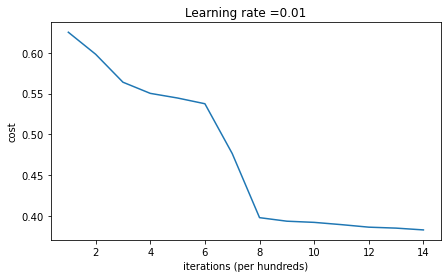

训练集：
Accuracy: 0.83
测试集：
Accuracy: 0.86
[[1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1
  1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
  0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
  1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0
  0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
  1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1
  0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1
  1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1
  1 1 1 1 0 0 0 1 1 1 1 0]]
[[1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1
  0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0
  1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0]]


In [15]:
parameters = model(train_X, train_Y, initialization = "random",is_polt=True)
print("训练集：")
predictions_train = init_utils.predict(train_X, train_Y, parameters)
print("测试集：")
predictions_test = init_utils.predict(test_X, test_Y, parameters)

print(predictions_train)
print(predictions_test)

我们把图绘制出来，看看分类的效果是怎么样的

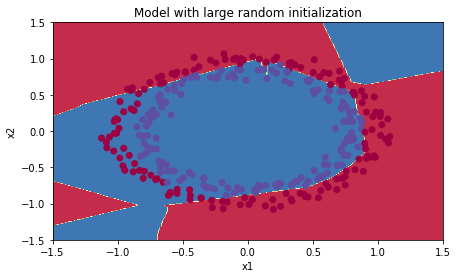

In [16]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 1.5])
axes.set_ylim([-1.5, 1.5])
init_utils.plot_decision_boundary(lambda x: init_utils.predict_dec(parameters, x.T), train_X, train_Y)

我们可以看到误差开始很高。这是因为由于具有较大的随机权重，最后一个激活(sigmoid)输出的结果非常接近于0或1，而当它出现错误时，它会导致非常高的损失。初始化参数如果没有很好地话会导致梯度消失、爆炸，这也会减慢优化算法。如果我们对这个网络进行更长时间的训练，我们将看到更好的结果，但是使用过大的随机数初始化会减慢优化的速度

总而言之，将权重初始化为非常大的时候其实效果并不好，下面我们试试小一点的参数值

## 4 - He initialization

使用$\sqrt{\frac{2}{上一层的维度}}$这个公式来初始化参数

In [17]:
def initialize_parameters_he(layers_dims):
    """
    参数：
        layers_dims - 列表，模型的层数和对应每一层的节点的数量
    返回
        parameters - 包含了所有W和b的字典
            W1 - 权重矩阵，维度为（layers_dims[1], layers_dims[0]）
            b1 - 偏置向量，维度为（layers_dims[1],1）
            ···
            WL - 权重矩阵，维度为（layers_dims[L], layers_dims[L -1]）
            b1 - 偏置向量，维度为（layers_dims[L],1）
    """
    
    np.random.seed(3)               # 指定随机种子
    parameters = {}
    L = len(layers_dims)            # 层数
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
        #使用断言确保我的数据格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l],layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l],1))
        
    return parameters

In [18]:
parameters = initialize_parameters_he([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
b2 = [[0.]]


现在，我们基本把参数W初始化到1附近了，我们实际运行看下结果

第0次迭代，成本值为：0.8830537463419761
第1000次迭代，成本值为：0.6879825919728063
第2000次迭代，成本值为：0.6751286264523371
第3000次迭代，成本值为：0.6526117768893807
第4000次迭代，成本值为：0.6082958970572937
第5000次迭代，成本值为：0.5304944491717495
第6000次迭代，成本值为：0.4138645817071793
第7000次迭代，成本值为：0.3117803464844441
第8000次迭代，成本值为：0.23696215330322556
第9000次迭代，成本值为：0.18597287209206828
第10000次迭代，成本值为：0.15015556280371808
第11000次迭代，成本值为：0.12325079292273548
第12000次迭代，成本值为：0.09917746546525937
第13000次迭代，成本值为：0.08457055954024274
第14000次迭代，成本值为：0.07357895962677366


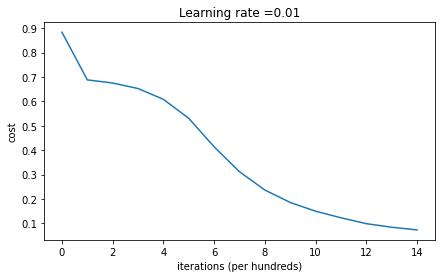

训练集:
Accuracy: 0.9933333333333333
测试集:
Accuracy: 0.96


In [19]:
parameters = model(train_X, train_Y, initialization = "he",is_polt=True)
print("训练集:")
predictions_train = init_utils.predict(train_X, train_Y, parameters)
print("测试集:")
init_utils.predictions_test = init_utils.predict(test_X, test_Y, parameters)

我们观察到误差越来越小，让我们来绘制一下预测的情况：

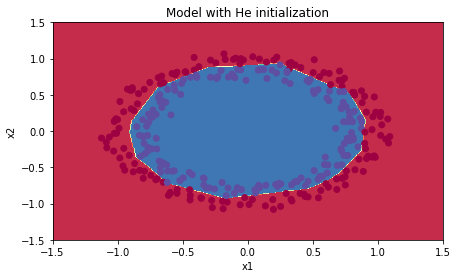

In [20]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 1.5])
axes.set_ylim([-1.5, 1.5])
init_utils.plot_decision_boundary(lambda x: init_utils.predict_dec(parameters, x.T), train_X, train_Y)

初始化的模型将蓝色、红色的点在少量的迭代中很好地分离出来，总结一下：
- 不同的初始化方法可能导致性能最终不同
- 随机初始化有助于打破对称，使得不同隐藏层的单元可以学习到不同的参数
- 初始化时，初始值不宜过大
- He初始化搭配ReLU激活函数常常可以得到不错的效果

# Regilarization
##  1 - Neural Network model
在深度学习中，如果数据集不够大，可能到会导致一些过拟合的问题，过拟合导致的结果是在训练集上有着很高的精确度，但在遇到新的样本时，精确度下降会很严重，为了避免过拟合问题，接下来我们来讲解正则化

问题描述：假设你现在是一个AI专家，你需要设计一个模型，可以用于推荐在足球场中守门员将球发至哪个位置可以让本队的球员抢到球的可能性更大。说白了，实际上就是一个二分类，一半是己方抢到球，一半就是对方抢到球，我们来看一下这个图
![](images/field_kiank.png)

我们来加载查看一下我们的数据集

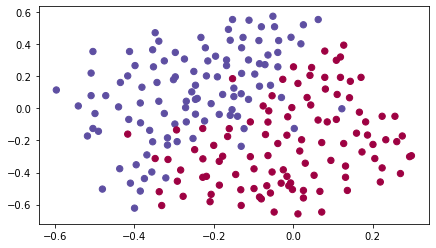

In [21]:
train_X, train_Y, test_X, test_Y = reg_utils.load_2D_dataset(is_plot=True)

每一个点代表球落下的可能的位置，蓝色代表己方的球员会抢到球，红色代表对手的球员会抢到球，我们要做的就是使用模型来画出一条线，来找到适合我方球员能抢到球的位置。
我们要做以下三件事，来对比出不同的模型的优劣：
- 不使用正则化
- 使用正则化
    - 使用L2正则化
    - 使用随机节点删除
    
我们来看一下我们的模型：
- 正则化模式：将lambda输入设置为非零值,使用"lambda"而不是"lambda",因为"lambda"是Python中的保留关键字
- 随机删除节点：将keep_prob设置为小于1的值

In [22]:
def model(X,Y,learning_rate=0.3,num_iterations=30000,print_cost=True,is_plot=True,lambd=0,keep_prob=1):
    """
    实现一个三层的神经网络：LINEAR ->RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    
    参数：
        X - 输入的数据，维度为(2, 要训练/测试的数量)
        Y - 标签，【0(蓝色) | 1(红色)】，维度为(1，对应的是输入的数据的标签)
        learning_rate - 学习速率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每迭代10000次打印一次，但是每1000次记录一个成本值
        is_polt - 是否绘制梯度下降的曲线图
        lambd - 正则化的超参数，实数
        keep_prob - 随机删除节点的概率
    返回
        parameters - 学习后的参数
    """
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0],20,3,1]
    
    #初始化参数
    parameters = reg_utils.initialize_parameters(layers_dims)
    
    #开始学习
    for i in range(0,num_iterations):
        #前向传播
        ##是否随机删除节点
        if keep_prob == 1:
            ###不随机删除节点
            a3 , cache = reg_utils.forward_propagation(X,parameters)
        elif keep_prob < 1:
            ###随机删除节点
            a3 , cache = forward_propagation_with_dropout(X,parameters,keep_prob)
        else:
            print("keep_prob参数错误！程序退出。")
            exit
        
        #计算成本
        ## 是否使用二范数
        if lambd == 0:
            ###不使用L2正则化
            cost = reg_utils.compute_cost(a3,Y)
        else:
            ###使用L2正则化
            cost = compute_cost_with_regularization(a3,Y,parameters,lambd)
        
        #反向传播
        ##可以同时使用L2正则化和随机删除节点，但是本次实验不同时使用。
        assert(lambd == 0  or keep_prob ==1)
        
        ##两个参数的使用情况
        if (lambd == 0 and keep_prob == 1):
            ### 不使用L2正则化和不使用随机删除节点
            grads = reg_utils.backward_propagation(X,Y,cache)
        elif lambd != 0:
            ### 使用L2正则化，不使用随机删除节点
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            ### 使用随机删除节点，不使用L2正则化
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        #更新参数
        parameters = reg_utils.update_parameters(parameters, grads, learning_rate)
        
        #记录并打印成本
        if i % 1000 == 0:
            ## 记录成本
            costs.append(cost)
            if (print_cost and i % 10000 == 0):
                #打印成本
                print("第" + str(i) + "次迭代，成本值为：" + str(cost))
        
    #是否绘制成本曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (x1,000)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    #返回学习后的参数
    return parameters

## 2 - Non-regularized

第0次迭代，成本值为：0.6557412523481002
第10000次迭代，成本值为：0.16329987525724196
第20000次迭代，成本值为：0.13851642423253843


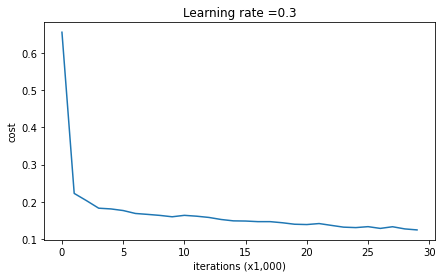

训练集:
Accuracy: 0.9478672985781991
测试集:
Accuracy: 0.915


In [23]:
parameters = model(train_X, train_Y,is_plot=True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

我们可以看到，对于训练集，精确度为94%；而对于测试集，精确度为91.5%。接下来，我们将分割曲线画出来

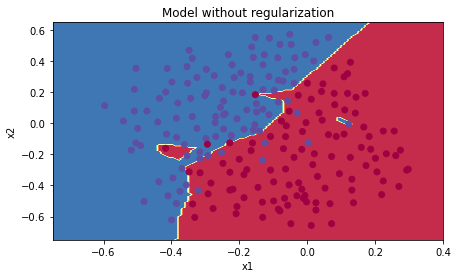

In [24]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

从图中可以看出，在无正则化时，分割曲线有了明显的过拟合特性。接下来，我们使用L2正则化

## 3 - L2 Regularization

![](images/L2_Regulartization.png)

In [25]:
def compute_cost_with_regularization(A3,Y,parameters,lambd):
    """
    实现公式2的L2正则化计算成本
    
    参数：
        A3 - 正向传播的输出结果，维度为（输出节点数量，训练/测试的数量）
        Y - 标签向量，与数据一一对应，维度为(输出节点数量，训练/测试的数量)
        parameters - 包含模型学习后的参数的字典
    返回：
        cost - 使用公式2计算出来的正则化损失的值
    
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = reg_utils.compute_cost(A3,Y)
    
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2))  + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

#当然，因为改变了成本函数，我们也必须改变向后传播的函数， 所有的梯度都必须根据这个新的成本值来计算。

def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    实现我们添加了L2正则化的模型的后向传播。
    
    参数：
        X - 输入数据集，维度为（输入节点数量，数据集里面的数量）
        Y - 标签，维度为（输出节点数量，数据集里面的数量）
        cache - 来自forward_propagation（）的cache输出
        lambda - regularization超参数，实数
    
    返回：
        gradients - 一个包含了每个参数、激活值和预激活值变量的梯度的字典
    """
    
    m = X.shape[1]
    
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = (1 / m) * np.dot(dZ3,A2.T) + ((lambd * W3) / m )
    db3 = (1 / m) * np.sum(dZ3,axis=1,keepdims=True)
    
    dA2 = np.dot(W3.T,dZ3)
    dZ2 = np.multiply(dA2,np.int64(A2 > 0))
    dW2 = (1 / m) * np.dot(dZ2,A1.T) + ((lambd * W2) / m)
    db2 = (1 / m) * np.sum(dZ2,axis=1,keepdims=True)
    
    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = (1 / m) * np.dot(dZ1,X.T) + ((lambd * W1) / m)
    db1 = (1 / m) * np.sum(dZ1,axis=1,keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

第0次迭代，成本值为：0.6974484493131264
第10000次迭代，成本值为：0.2684918873282239
第20000次迭代，成本值为：0.2680916337127301


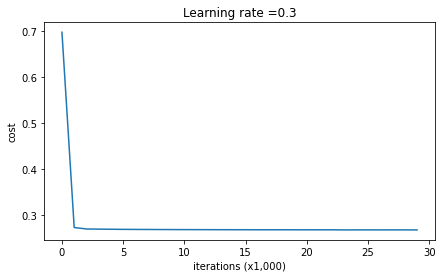

使用正则化，训练集:
Accuracy: 0.9383886255924171
使用正则化，测试集:
Accuracy: 0.93


In [26]:
parameters = model(train_X, train_Y, lambd=0.7,is_plot=True)
print("使用正则化，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用正则化，测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

来看一下分类的结果

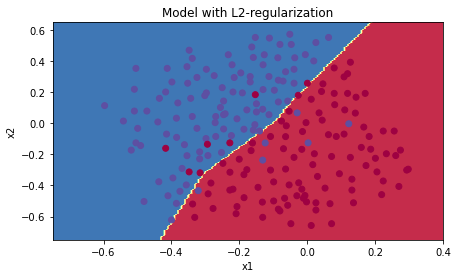

In [27]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

λ的值是可以使用开发集调整时的超参数。L2正则化会使决策边界更加平滑。如果λ太大，也可能会“过度平滑”，从而导致模型高偏差。L2正则化实际上在做什么？L2正则化依赖于较小权重的模型比具有较大权重的模型更简单这样的假设，因此，通过削减成本函数中权重的平方值，可以将所有权重值逐渐改变到到较小的值。权值数值高的话会有更平滑的模型，其中输入变化时输出变化更慢，但是你需要花费更多的时间

L2正则化对以下内容有影响：
- 成本计算：正则化的计算需要添加到成本函数中
- 反向传播功能：在权重矩阵方面，梯度计算时也要依据正则化来做出相应的计算
- 重量变小（"重量衰减"）：权重被逐渐改变到较小的值

## 4 - Dropout

最后，我们使用Dropout来进行正则化，Dropout的原理就是每次迭代过程中随机将其中的一些节点失效。当我们关闭一些节点时，我们实际上修改了我们的模型。背后的想法是，在每次迭代时，我们都会训练一个只使用一部分神经元的不同模型。随着迭代次数的增加，我们的模型的节点会对其他特定节点的激活变得不那么敏感，因为其他节点可能在任何时候会失效

![](images/Dropout_1.gif)
第二层启用随机节点删除

在每一次迭代中，关闭（设置为零）一层的每个神经元，概率为$1 - keep\_prob$，我们在这里保持概率为$keep\_prob$（这里为50％）。丢弃的节点都不参与迭代时的前向和后向传播
![](images/Dropout_2.gif)

下面我们将关闭第一层和第三层的一些节点，我们需要做以下四步：
- 在视频中，吴恩达老师讲解了使用`np.random.rand()`来初始化和$a^{[1]}$具有相同维度的$d^{[1]}$，在这里，我们将使用向量化实现，我们先来实现一个和$A^{[1]}$相同的随机矩阵$D^{[1]} = [d^{1} d^{1} … d^{1}]$
- 如果$D^{[1]}$低于keep_prob的值，我们就把它设为0，如果高于keep_prob的值我们就设置为1
- 把$A^{[1]}$更新为$A^{[1]}*D^{[1]}$。我们已经关闭了一些节点，我们可以使用$D^{[1]}$作为掩码。当我们做矩阵相乘的时候，关闭的那些节点(值为0)就不会参数计算，因为0乘以任何值都为0
- 使用$A^{[1]}$除以keep_prob，这样做的话我们通过缩放就可以在计算成本的时候仍然具有相同的期望值，这叫做反向dropout

In [28]:
def forward_propagation_with_dropout(X,parameters,keep_prob=0.5):
    """
    实现具有随机舍弃节点的前向传播。
    LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    参数：
        X  - 输入数据集，维度为（2，示例数）
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
            W1  - 权重矩阵，维度为（20,2）
            b1  - 偏向量，维度为（20,1）
            W2  - 权重矩阵，维度为（3,20）
            b2  - 偏向量，维度为（3,1）
            W3  - 权重矩阵，维度为（1,3）
            b3  - 偏向量，维度为（1,1）
        keep_prob  - 随机删除的概率，实数
    返回：
        A3  - 最后的激活值，维度为（1,1），正向传播的输出
        cache - 存储了一些用于计算反向传播的数值的元组
    """
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    #LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = reg_utils.relu(Z1)
    
    #下面的步骤1-4对应于上述的步骤1-4。
    D1 = np.random.rand(A1.shape[0],A1.shape[1])    #步骤1：初始化矩阵D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                             #步骤2：将D1的值转换为0或1（使​​用keep_prob作为阈值）
    A1 = A1 * D1                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A1 = A1 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值
    """
    #不理解的同学运行一下下面代码就知道了。
    import numpy as np
    np.random.seed(1)
    A1 = np.random.randn(1,3)
    
    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    keep_prob=0.5
    D1 = D1 < keep_prob
    print(D1)
    
    A1 = 0.01
    A1 = A1 * D1
    A1 = A1 / keep_prob
    print(A1)
    """
    
    Z2 = np.dot(W2,A1) + b2
    A2 = reg_utils.relu(Z2)
    
    #下面的步骤1-4对应于上述的步骤1-4。
    D2 = np.random.rand(A2.shape[0],A2.shape[1])    #步骤1：初始化矩阵D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                             #步骤2：将D2的值转换为0或1（使​​用keep_prob作为阈值）
    A2 = A2 * D2                                    #步骤3：舍弃A1的一些节点（将它的值变为0或False）
    A2 = A2 / keep_prob                             #步骤4：缩放未舍弃的节点(不为0)的值
    
    Z3 = np.dot(W3, A2) + b3
    A3 = reg_utils.sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

改变了前向传播算法，我们也需要改变后向传播算法，使用存储在缓存中的掩码$D^{[1]}$和$D^{[2]}$将舍弃的节点位置信息添加到第一个和第二个隐藏层

In [29]:
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    """
    实现我们随机删除的模型的后向传播。
    参数：
        X  - 输入数据集，维度为（2，示例数）
        Y  - 标签，维度为（输出节点数量，示例数量）
        cache - 来自forward_propagation_with_dropout（）的cache输出
        keep_prob  - 随机删除的概率，实数
    
    返回：
        gradients - 一个关于每个参数、激活值和预激活变量的梯度值的字典
    """
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1 / m) * np.dot(dZ3,A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA2 = dA2 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1          # 步骤1：使用正向传播期间相同的节点，舍弃那些关闭的节点（因为任何数乘以0或者False都为0或者False）
    dA1 = dA1 / keep_prob   # 步骤2：缩放未舍弃的节点(不为0)的值

    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

我们前向和后向传播的函数都写好了，现在用dropout运行模型（keep_prob = 0.86）跑一波。这意味着在每次迭代中，程序都可以14％的概率关闭第1层和第2层的每个神经元。调用的时候：
- 使用forward_propagation_with_dropout而不是forward_propagation
- 使用backward_propagation_with_dropout而不是backward_propagation

第0次迭代，成本值为：0.6543912405149825


C:\Users\20919\PycharmProjects\wuenda-DeepLearning\Improve deep neural networks\Initialization,Regularization,Gradient Checking\reg_utils.py:121: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
C:\Users\20919\PycharmProjects\wuenda-DeepLearning\Improve deep neural networks\Initialization,Regularization,Gradient Checking\reg_utils.py:121: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第10000次迭代，成本值为：0.061016986574905605
第20000次迭代，成本值为：0.060582435798513114


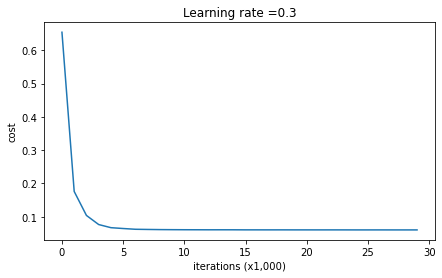

使用随机删除节点，训练集:
Accuracy: 0.9289099526066351
使用随机删除节点，测试集:
Accuracy: 0.95


In [30]:
parameters = model(train_X, train_Y, keep_prob=0.86, learning_rate=0.3,is_plot=True)

print("使用随机删除节点，训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("使用随机删除节点，测试集:")
reg_utils.predictions_test = reg_utils.predict(test_X, test_Y, parameters)

来看看分类情况

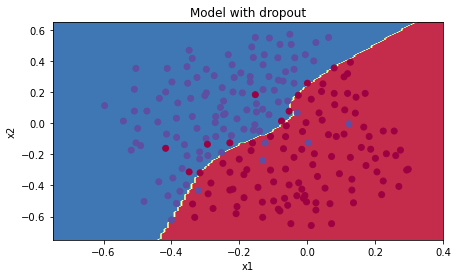

In [31]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)

可以观察到，正则化会把训练集的准确的降低，但是测试集的准确度提高了，故这个还是成功了

# Gradient Checking

假设你现在是一个全球移动支付团队中的一员，现在需要建立一个深度学习模型去判断用户账户在进行付款的时候是否是被黑客入侵的

但是，在我们执行反向传播的计算过程中，反向传播函数的计算过程是比较复杂的。为了验证我们得到的反向传播函数是否正确，现在你需要编写一些代码来验证反向传播函数的正确性

反向传播计算梯度$\frac{\partial J}{\partial \theta}$,θ表示模型中的参数，使用前向传播和损失函数计算J，因为向前传播相对容易实现，所以您确信自己得到了正确的结果，所以您几乎100％确定您正确计算了J的成本。因此，您可以使用您的代码来计算J来验证计算的代码$\frac{\partial J}{\partial \theta}$

让我们回头看一下导数的定义：

![](images/gradient.png)

- $\frac{\partial J}{\partial \theta}$ 是你确保想计算正确的值
- 你可以计算J(θ + ε)和J（θ - ε），因为你确信你对J的计算结果是正确的

## 1 - dimensional gradient checking

先来看一下一维线性模型的梯度检查计算过程：
![](images/1Dgrad_kiank.png)

In [32]:
def forward_propagation(x,theta):
    """
    
    实现图中呈现的线性前向传播（计算J）（J（theta）= theta * x）
    
    参数：
    x  - 一个实值输入
    theta  - 参数，也是一个实数
    
    返回：
    J  - 函数J的值，用公式J（theta）= theta * x计算
    """
    J = np.dot(theta,x)
    
    return J

In [33]:
#测试forward_propagation
print("-----------------测试forward_propagation-----------------")
x, theta = 2, 4
J = forward_propagation(x, theta)
print ("J = " + str(J))

-----------------测试forward_propagation-----------------
J = 8


前向传播有了，再来看一下反向传播：

In [34]:
def backward_propagation(x,theta):
    """
    计算J相对于θ的导数。
    
    参数：
        x  - 一个实值输入
        theta  - 参数，也是一个实数
    
    返回：
        dtheta  - 相对于θ的成本梯度
    """
    dtheta = x
    
    return dtheta

In [35]:
#测试backward_propagation
print("-----------------测试backward_propagation-----------------")
x, theta = 2, 4
dtheta = backward_propagation(x, theta)
print ("dtheta = " + str(dtheta))

-----------------测试backward_propagation-----------------
dtheta = 2


![](images/gradient_check1.png)

In [36]:
def gradient_check(x,theta,epsilon=1e-7):
    """
    
    实现图中的反向传播。
    
    参数：
        x  - 一个实值输入
        theta  - 参数，也是一个实数
        epsilon  - 使用公式（3）计算输入的微小偏移以计算近似梯度
    
    返回：
        近似梯度和后向传播梯度之间的差异
    """
    
    #使用公式（3）的左侧计算gradapprox。
    thetaplus = theta + epsilon                               # Step 1
    thetaminus = theta - epsilon                              # Step 2
    J_plus = forward_propagation(x, thetaplus)                # Step 3
    J_minus = forward_propagation(x, thetaminus)              # Step 4
    gradapprox = (J_plus - J_minus) / (2 * epsilon)           # Step 5
    
    
    #检查gradapprox是否足够接近backward_propagation（）的输出
    grad = backward_propagation(x, theta)
    
    numerator = np.linalg.norm(grad - gradapprox)                      # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)    # Step 2'
    difference = numerator / denominator                               # Step 3'
    
    if difference < 1e-7:
        print("梯度检查：梯度正常!")
    else:
        print("梯度检查：梯度超出阈值!")
    
    return difference

In [37]:
#测试gradient_check
print("-----------------测试gradient_check-----------------")
x, theta = 2, 4
difference = gradient_check(x, theta)
print("difference = " + str(difference))

-----------------测试gradient_check-----------------
梯度检查：梯度正常!
difference = 2.919335883291695e-10


## 2 - N-dimensional gradient checking

N维参数是怎样计算的呢?
![](images/NDgrad_kiank.png)

In [38]:
def forward_propagation_n(X,Y,parameters):
    """
    实现图中的前向传播（并计算成本）。
    
    参数：
        X - 训练集为m个例子
        Y -  m个示例的标签
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
            W1  - 权重矩阵，维度为（5,4）
            b1  - 偏向量，维度为（5,1）
            W2  - 权重矩阵，维度为（3,5）
            b2  - 偏向量，维度为（3,1）
            W3  - 权重矩阵，维度为（1,3）
            b3  - 偏向量，维度为（1,1）
   
    返回：
        cost - 成本函数（logistic）
    """
    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1,X) + b1
    A1 = gc_utils.relu(Z1)
    
    Z2 = np.dot(W2,A1) + b2
    A2 = gc_utils.relu(Z2)
    
    Z3 = np.dot(W3,A2) + b3
    A3 = gc_utils.sigmoid(Z3)
    
    #计算成本
    logprobs = np.multiply(-np.log(A3), Y) + np.multiply(-np.log(1 - A3), 1 - Y)
    cost = (1 / m) * np.sum(logprobs)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return cost, cache

def backward_propagation_n(X,Y,cache):
    """
    实现图中所示的反向传播。
    
    参数：
        X - 输入数据点（输入节点数量，1）
        Y - 标签
        cache - 来自forward_propagation_n（）的cache输出
    
    返回：
        gradients - 一个字典，其中包含与每个参数、激活和激活前变量相关的成本梯度。
    """
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1. / m) * np.dot(dZ3,A2.T)
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    #dW2 = 1. / m * np.dot(dZ2, A1.T) * 2  # Should not multiply by 2
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    #db1 = 4. / m * np.sum(dZ1, axis=1, keepdims=True) # Should not multiply by 4
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
 
    return gradients

现在，运行反向传播函数

In [39]:
def backward_propagation_n(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input datapoint, of shape (input size, 1)
    Y -- true "label"
    cache -- cache output from forward_propagation_n()
    
    Returns:
    gradients -- A dictionary with the gradients of the cost with respect to each parameter, activation and pre-activation variables.
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1. / m * np.dot(dZ2, A1.T) * 2  # Should not multiply by 2
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 4. / m * np.sum(dZ1, axis=1, keepdims=True) # Should not multiply by 4
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

![](images/gradient_check_n.png)
![](images/gradient_check_code.png)

In [45]:
def gradient_check_n(parameters,gradients,X,Y,epsilon=1e-7):
    """
    检查backward_propagation_n是否正确计算forward_propagation_n输出的成本梯度
    
    参数：
        parameters - 包含参数“W1”，“b1”，“W2”，“b2”，“W3”，“b3”的python字典：
        grad_output_propagation_n的输出包含与参数相关的成本梯度。
        x  - 输入数据点，维度为（输入节点数量，1）
        y  - 标签
        epsilon  - 计算输入的微小偏移以计算近似梯度
    
    返回：
        difference - 近似梯度和后向传播梯度之间的差异
    """
    #初始化参数
    parameters_values , keys = gc_utils.dictionary_to_vector(parameters) #keys用不到
    grad = gc_utils.gradients_to_vector(gradients)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters,1))
    J_minus = np.zeros((num_parameters,1))
    gradapprox = np.zeros((num_parameters,1))
    
    #计算gradapprox
    for i in range(num_parameters):
        #计算J_plus [i]。输入：“parameters_values，epsilon”。输出=“J_plus [i]”
        thetaplus = np.copy(parameters_values)                                                  # Step 1
        thetaplus[i][0] = thetaplus[i][0] + epsilon                                             # Step 2
        J_plus[i], cache = forward_propagation_n(X,Y,gc_utils.vector_to_dictionary(thetaplus))  # Step 3 ，cache用不到
        
        #计算J_minus [i]。输入：“parameters_values，epsilon”。输出=“J_minus [i]”。
        thetaminus = np.copy(parameters_values)                                                 # Step 1
        thetaminus[i][0] = thetaminus[i][0] - epsilon                                           # Step 2        
        J_minus[i], cache = forward_propagation_n(X,Y,gc_utils.vector_to_dictionary(thetaminus))# Step 3 ，cache用不到
        
        #计算gradapprox[i]
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
        
    #通过计算差异比较gradapprox和后向传播梯度。
    numerator = np.linalg.norm(grad - gradapprox)                                     # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)                   # Step 2'
    difference = numerator / denominator                                              # Step 3'
    
    if difference > 1e-7:
        print("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

In [46]:
X, Y, parameters = gradient_check_n_test_case()

cost, cache = forward_propagation_n(X, Y, parameters)
gradients = backward_propagation_n(X, Y, cache)
difference = gradient_check_n(parameters, gradients, X, Y)

There is a mistake in the backward propagation! difference = 0.2850931566540251


![](images/gradient_out.png)